<a href="https://colab.research.google.com/github/Hellork780/Data-Driven-Insights-Tesla-Stock-Analysis-Using-R-/blob/main/Machine_Learning_for_stock_price_prediction0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1:Install & Import Required libraries**






In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

**Step 2: Fetch stock data**

In [ ]:
#Fetch stock data
stock_symbol = "Reliance.NS"
stock_data = yf.Ticker(stock_symbol)
df = stock_data.history(period="5y") #Get % years of data

# keep only "Close" Price
df = df[["Close"]]
df.dropna(inplace=True) # Remove missing values
df.head()

,Close
Date,
2020-02-13 00:00:00+05:30,657.167053
2020-02-14 00:00:00+05:30,663.162964
2020-02-17 00:00:00+05:30,658.994812
2020-02-18 00:00:00+05:30,654.157959
2020-02-19 00:00:00+05:30,670.384766


**Step 3: Prepare Data for Machine Learning**
Normalize data ( Scaling Between 0 and 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

**Create Sequence for LSTM**

LSTM is require *past data to predict future prices*. We will use 60 days of data to predict the next day.



In [ ]:
import numpy as np

x, y = [], []  # Initialize empty lists
window_size = 60  # Use past 60 days to predict the next day

# Loop through data to create sequences
for i in range(window_size, len(df_scaled)):
    x.append(df_scaled[i-window_size:i, 0])  # Take past `window_size` days
    y.append(df_scaled[i, 0])  # Predict the next day's value

# Convert lists to NumPy arrays
X, Y = np.array(x), np.array(y)

# Reshape data to fit LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Correct reshape


**Step 4: Train the LSTM Model**


1-Split Data into Training & Testing sets

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data: 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


2-Build an LSTM Model

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)  # Output: Next day's price
])

model.compile(optimizer="adam", loss="mean_squared_error")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3-Train the Model

In [ ]:
model.fit(x_train, y_train, batch_size=16, epochs=20)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0487
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0018
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0013
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.3276e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 9.1462e-04
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.4959e-04
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.8061e-04
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 7.7371e-04
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.6199e-04
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.7367e-04
Epoch 13/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 6.9688e-04
Epoch 14/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.9072e-04
Epoch 15/20
59/59 ━━━━━━━━━━━━━━━━━

**Step 5: Predict Future Stock Prices**



In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


*Plot Actual vs Predicted Prices*

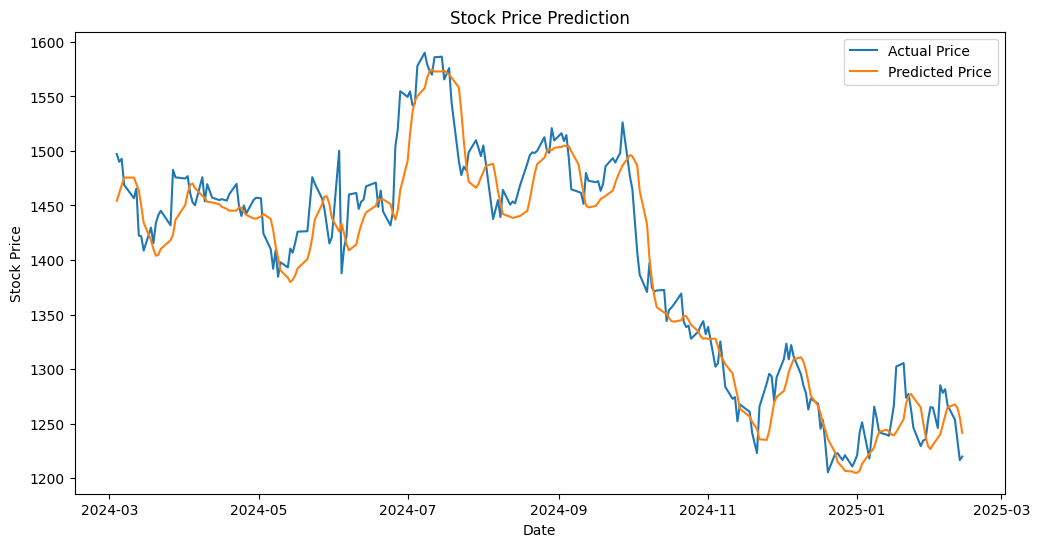

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual Price")
plt.plot(df.index[-len(y_test):], predictions, label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()

**Step 6:Predict Next Day's Stock Price**

In [ ]:
last_60_days = df_scaled[-60:]  # Get last 60 days
last_60_days = np.reshape(last_60_days, (1, 60, 1))  # Reshape for LSTM

predicted_price = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)  # Convert back

print(f"Predicted Stock Price for Tomorrow: {predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Stock Price for Tomorrow: 1228.05
